In [1]:
from __future__ import annotations
import numpy as np
import itertools
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from scipy.optimize import linprog
from typing import Dict, List, Optional, Tuple, Iterable
from scipy.optimize import linprog
import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')

from geobin import Region, Tree, RegionTree, TreeNode

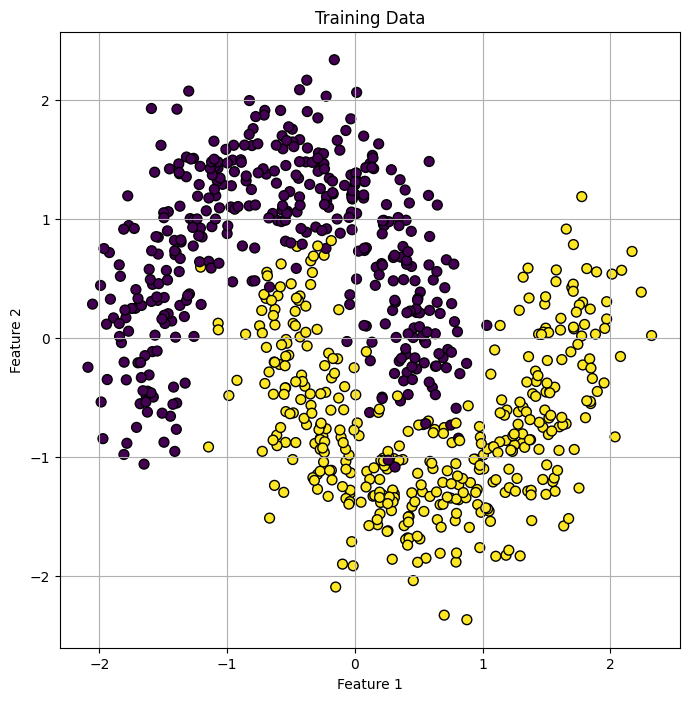

In [2]:
from src_experiment import get_moons_data, train_model, NeuralNet
train, test = get_moons_data(feature_noise=.2)
all_features = []
all_labels = []

for features, labels in train:
    all_features.append(features.detach().cpu())
    all_labels.append(labels.detach().cpu())

# Combine batches into one large array
import torch
X = torch.cat(all_features, dim=0).numpy()
y = torch.cat(all_labels, dim=0).numpy()

plt.figure(figsize=(8,8))

# 3. Plot using the first two columns (dimensions) of the features
# X[:, 0] is Feature 1, X[:, 1] is Feature 2
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)

plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

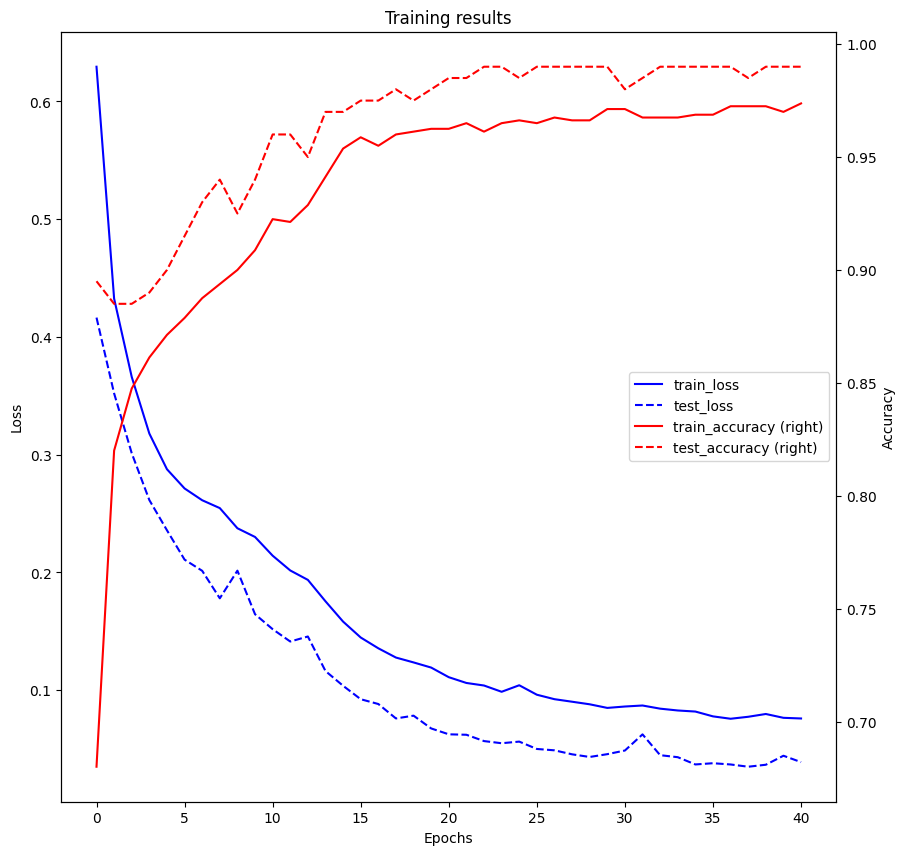

In [3]:
from visualization import plot_training
from src_experiment import get_test_data
hidden_sizes = [0,15,10,5,1]

ActNet = NeuralNet(
    input_size = 2,
    hidden_sizes = hidden_sizes[1:-1],
    num_classes=1,
    seed=3,
)

res, = train_model(ActNet, train, test, epochs=41, save_everyth_epoch=10, SAVE_STATES=True, savepath=get_test_data())
plot_training(res)

In [4]:
trees = {}
tot_start = time.time()
for epoch in [0,10,20,30,40]:
    state_dict_path = get_test_data() / "state_dicts" / f"epoch{epoch}.pth"
    state = torch.load(state_dict_path)
    start = time.time()
    print(f"\n--- Epoch {epoch} ---")
    tree = Tree(state)
    tree.construct_tree(verbose=True)
    trees[epoch] = tree
    end = time.time()
    print(f"Duration: {end-start:.2f} s")
tot_end = time.time()
print(f"Total duration: {tot_end-tot_start:.2f} s")


--- Epoch 0 ---


Processing layer 1:   0%|          | 0/1 [00:00<?, ?it/s]

Duration: 21.49 s

--- Epoch 10 ---


Duration: 21.16 s

--- Epoch 20 ---


Duration: 21.25 s

--- Epoch 30 ---


Duration: 19.94 s

--- Epoch 40 ---


Duration: 20.23 s
Total duration: 104.15 s


In [5]:
#suitable up to a [6,6,6] hidden layer configuration

# oldtrees = {}
# tot_start = time.time()
# for epoch, state in states.items():
#     start = time.time()
#     print(f"\n--- Epoch {epoch} ---")
#     tree = RegionTree(state)
#     tree.build_tree()
#     oldtrees[epoch] = tree
#     end = time.time()
#     print(f"Duration: {end-start:.2f} s")
# tot_end = time.time()
# print(f"Total duration: {tot_end-tot_start:.2f} s")

# Investigate trees

In [6]:
import itertools
t0 = trees[0]
# ot0 = oldtrees[0]
n_theo_all = 2**np.cumsum(np.array(hidden_sizes))

# prev_layer_nodes = [ot0.root]
for i in range(t0.L):
    # old_nodes = []
    # old_nodes.extend(itertools.chain.from_iterable([n.get_children() for n in prev_layer_nodes]))
    n_new = len(t0.get_regions_at_layer(i+1))
    # n_old = len(old_nodes)
    n_theo = n_theo_all[i+1]
    
    print(f"\nLayer: {i+1}\nRegions (new): {n_new}\nRegions (tot): {n_theo}\n")
    # print(f"\nLayer: {i+1}\nRegions (new): {n_new}\nRegions (old): {n_old}\nRegions (tot): {n_theo}\n")
    # prev_layer_nodes = old_nodes
    


Layer: 1
Regions (new): 121
Regions (tot): 32768


Layer: 2
Regions (new): 339
Regions (tot): 33554432


Layer: 3
Regions (new): 2899
Regions (tot): 1073741824


Layer: 4
Regions (new): 4902
Regions (tot): 2147483648



# Visualization

(<Figure size 1500x1200 with 20 Axes>,
 array([[<Axes: title={'center': 'Epoch 0'}, ylabel='Layer 1'>,
         <Axes: title={'center': 'Epoch 10'}>,
         <Axes: title={'center': 'Epoch 20'}>,
         <Axes: title={'center': 'Epoch 30'}>,
         <Axes: title={'center': 'Epoch 40'}>],
        [<Axes: ylabel='Layer 2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

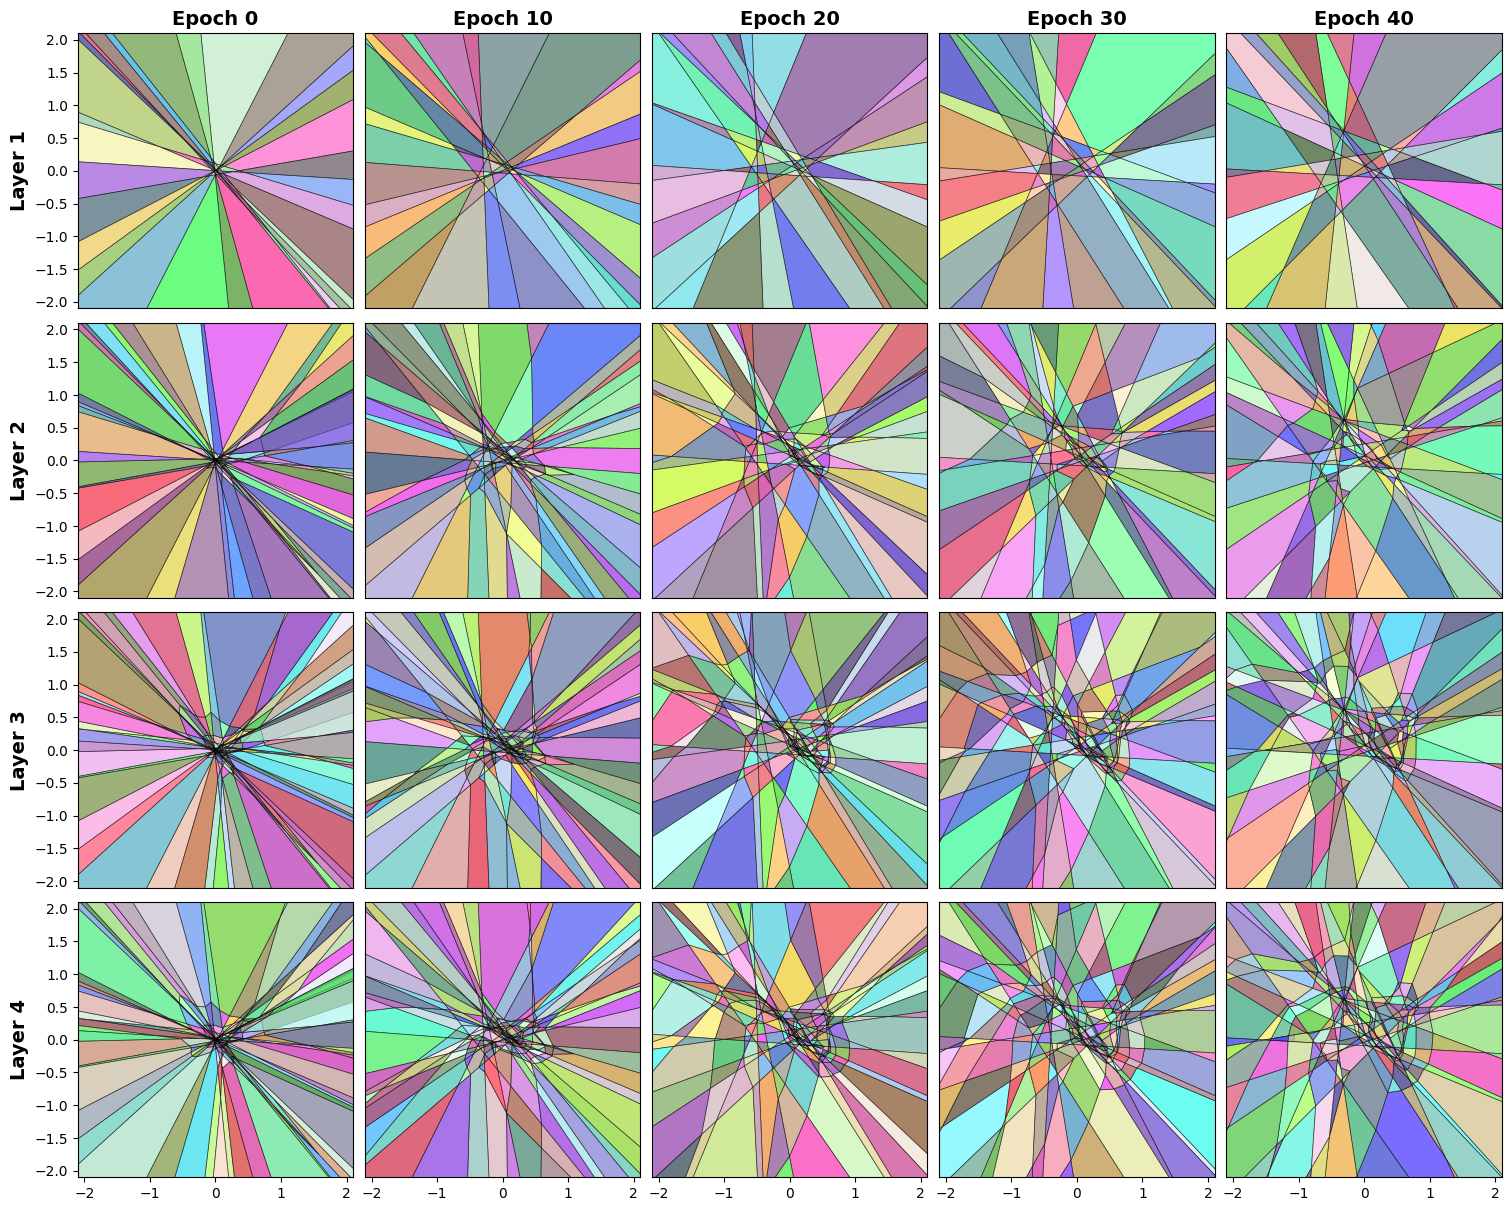

In [7]:
from visualization import plot_epoch_layer_grid
plot_epoch_layer_grid(trees, bound=2.1)